# Analysis of Anna Karenina data

### Import dependencies

In [47]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import gseapy as gp
from matplotlib_venn import venn2
from matplotlib.patches import Patch
import seaborn as sns
import importlib

import run_ebseq
importlib.reload(run_ebseq)

PALETTE = [
    "#0652ff", #  electric blue
    "#e50000", #  red
    "#9a0eea", #  violet
    "#01b44c", #  shamrock
    "#fedf08", #  dandelion
    "#00ffff", #  cyan
    "#89fe05", #  lime green
    "#a2cffe", #  baby blue
    "#dbb40c", #  gold
    "#029386", #  teal
    "#ff9408", #  tangerine
    "#d8dcd6", #  light grey
    "#80f9ad", #  seafoam
    "#3d1c02", #  chocolate
    "#fffd74", #  butter yellow
    "#536267", #  gunmetal
    "#f6cefc", #  very light purple
    "#650021", #  maroon
    "#020035", #  midnight blue
    "#b0dd16", #  yellowish green
    "#9d7651", #  mocha
    "#c20078", #  magenta
    "#380282", #  indigo
    "#ff796c", #  salmon
    "#874c62"  #  dark muave
]

FDR_THRESH = 0.1


def run_EBSeq(genes, cond_1_cats, cond_2_cats, qqplot_f, mean_count_thresh=10):
    # Get samples in two conditions
    keep_samples = []
    conditions = []
    for sample, cat in sample_to_category.items():
        if cat in cond_1_cats:
            keep_samples.append(sample)
            conditions.append('condition_1')
    for sample, cat in sample_to_category.items():
        if cat in cond_2_cats:
            keep_samples.append(sample)
            conditions.append('condition_2')
    df_counts_filt = df_counts[keep_samples]
    #df_counts_filt = df_counts_filt.loc[genes]
    
    mean_expr = np.mean(np.array(df_counts), axis=1)
    #mean_expr = sorted(mean_expr)
    keep_genes = [
        gene
        for gene, mean_e in zip(df_counts_filt.index, mean_expr)
        if mean_e > mean_count_thresh
    ]
    df_counts_filt = df_counts_filt.loc[keep_genes]
    print("Shape of matrix after filtering: ", df_counts_filt.shape)
    #print(mean_expr.shape)
    #print(mean_expr)
    #sns.histplot(mean_expr[10000:15000])
    #plt.show()
    
    # Run EBseq
    ebseq_df = run_ebseq.runEBSeq(df_counts_filt, conditions, qqplot_f=qqplot_f)    
    ebseq_df.index = df_counts_filt.index
    return ebseq_df

def run_analysis(gene_set, cond_1, cond_2, plot_title, out_f):
    ebseq_df = run_EBSeq(gene_set, [cond_1], [cond_2], qqplot_f=f'{out_f}.QQPlot.png')
    #print(ebseq_df)
    #print(ebseq_df.loc[ebseq_df['PPEE'] < 0.05])

    gene_set = sorted(set(gene_set) & set(ebseq_df.index))
    
    da = []
    for gene in gene_set:
        samples = category_to_samples[cond_1]
        for e in df_log2cpm.transpose().loc[samples][gene]:
            da.append((cond_1, gene, e))
        samples = category_to_samples[cond_2]
        for e in df_log2cpm.transpose().loc[samples][gene]:
            da.append((cond_2, gene, e))
    df_barplot = pd.DataFrame(
        data=da,
        columns=['Category', 'Gene', r'Expression ($log_2$(CPM+1))']
    )
    sns.boxplot(data=df_barplot, x='Gene', y=r'Expression ($log_2$(CPM+1))', hue='Category')
    plt.xticks(rotation='vertical')

    for gene, k in zip(gene_set, plt.gca().get_xmajorticklabels()):
        if ebseq_df.loc[gene]['PPEE'] < FDR_THRESH and ebseq_df.loc[gene]['PostFC'] > 1:
            k.set_color(sns.color_palette()[0])
        elif ebseq_df.loc[gene]['PPEE'] < FDR_THRESH and ebseq_df.loc[gene]['PostFC'] < 1:
            k.set_color(sns.color_palette()[1])
        else:
            k.set_color('black')
    plt.title(plot_title)
    plt.tight_layout()
    plt.savefig(f'{out_f}.tiff', bbox_layout='tight',format='tiff', dpi=300)
    plt.show()
    
    # Restrict only to genes that are DE and up in cond_1
    sns.set_palette('colorblind')
    da = []
    for gene in gene_set:
        if not(ebseq_df.loc[gene]['PPEE'] < FDR_THRESH and ebseq_df.loc[gene]['PostFC']):
            continue
        samples = category_to_samples[cond_1]
        for e in df_log2cpm.transpose().loc[samples][gene]:
            da.append((cond_1, gene, e))
        samples = category_to_samples[cond_2]
        for e in df_log2cpm.transpose().loc[samples][gene]:
            da.append((cond_2, gene, e))
    if len(da) > 0:
        df_barplot = pd.DataFrame(
            data=da,
            columns=['Category', 'Gene', r'Expression ($log_2$(CPM+1))']
        )
        sns.boxplot(data=df_barplot, x='Gene', y=r'Expression ($log_2$(CPM+1))', hue='Category')
        plt.xticks(rotation='vertical')
        plt.title(plot_title)
        plt.tight_layout()
        plt.savefig(f'{out_f}.genes_agree.tiff', bbox_layout='tight',format='tiff', dpi=300)
        plt.show()
        
        
def run_analysis_COUNTS(gene_set, cond_1, cond_2, plot_title, out_f):
    ebseq_df = run_EBSeq(gene_set, [cond_1], [cond_2])
    print(ebseq_df)
    ebseq_df.index = gene_set
    print()
    print(ebseq_df)
    #print(ebseq_df.loc[ebseq_df['PPEE'] < 0.05])

    da = []
    for gene in gene_set:
        samples = category_to_samples[cond_1]
        for e in df_counts.transpose().loc[samples][gene]:
            da.append((cond_1, gene, e))
        samples = category_to_samples[cond_2]
        for e in df_counts.transpose().loc[samples][gene]:
            da.append((cond_2, gene, e))
    df_barplot = pd.DataFrame(
        data=da,
        columns=['Category', 'Gene', r'Expression ($log_2$(CPM+1))']
    )
    sns.boxplot(data=df_barplot, x='Gene', y=r'Expression ($log_2$(CPM+1))', hue='Category')
    plt.xticks(rotation='vertical')

    for gene, k in zip(gene_set, plt.gca().get_xmajorticklabels()):
        if ebseq_df.loc[gene]['PPEE'] < FDR_THRESH and ebseq_df.loc[gene]['PostFC'] > 1:
            k.set_color(sns.color_palette()[0])
        elif ebseq_df.loc[gene]['PPEE'] < FDR_THRESH and ebseq_df.loc[gene]['PostFC'] < 1:
            k.set_color(sns.color_palette()[1])
        else:
            k.set_color('black')
    plt.title(plot_title)
    plt.ylim((0,4000))
    plt.tight_layout()
    plt.savefig(f'{out_f}.tiff', bbox_layout='tight',format='tiff', dpi=300)
    plt.show()
    
    # Restrict only to genes that are DE and up in cond_1
    sns.set_palette('colorblind')
    da = []
    for gene in gene_set:
        if not(ebseq_df.loc[gene]['PPEE'] < 0.05 and ebseq_df.loc[gene]['PostFC'] > 1.5):
            continue
        samples = category_to_samples[cond_1]
        for e in df_counts.transpose().loc[samples][gene]:
            da.append((cond_1, gene, e))
        samples = category_to_samples[cond_2]
        for e in df_counts.transpose().loc[samples][gene]:
            da.append((cond_2, gene, e))
    if len(da) > 0:
        df_barplot = pd.DataFrame(
            data=da,
            columns=['Category', 'Gene', r'Expression ($log_2$(CPM+1))']
        )
        sns.boxplot(data=df_barplot, x='Gene', y=r'Expression ($log_2$(CPM+1))', hue='Category')
        plt.xticks(rotation='vertical')
        plt.tight_layout()
        plt.savefig(f'{out_f}.genes_agree.tiff', bbox_layout='tight',format='tiff', dpi=300)
        plt.show()

### Load data

In [2]:
#df = pd.read_csv('Normalized_Matrix_rmDuplicates.tsv', sep='\t', index_col=0)
df = pd.read_csv('log2Top15_GE.csv', sep=',', index_col=0)
df = df.transpose()
df

gene_id,0610012H03RIK,1300002K09RIK,1700012B07RIK,1700023E05RIK,1700024P16RIK,1700026L06RIK,1700065D16RIK,1700084C01RIK,1810009J06RIK,1810011H11RIK,...,ZFP850,ZFP872,ZFYVE28,ZG16,ZIM1,ZMAT4,ZMYND10,ZMYND15,ZPLD1,ZRSR1
T729_T2D,2.139972,0.904790,0.886001,3.321288,3.018142,-0.120079,1.039359,0.115235,8.683662,1.616519,...,-0.574708,6.622929,1.575318,6.028198,0.208431,-0.365326,0.392490,1.013058,3.663532,9.740166
T737_T2H,2.139972,5.183519,2.610027,2.585681,0.535294,2.835978,0.290897,2.265794,1.777734,1.616519,...,4.803432,2.628355,1.575318,17.568044,4.001286,4.892439,7.178433,6.799393,-0.251033,5.267107
Q203_E18.5,2.381888,6.241376,3.686575,3.723977,2.008352,6.217215,0.137820,0.935641,-1.883501,-0.875018,...,5.531309,0.997768,2.613695,5.343438,6.101912,0.178346,5.138722,1.220941,4.036839,7.300163
Q204_P1,3.576088,3.045160,-0.131401,2.102020,2.900100,5.698393,3.061920,1.955748,4.057370,-0.875018,...,4.840375,1.108050,0.935311,3.922136,5.377470,4.556858,3.974061,-0.510507,2.212631,6.845432
T222_T1D,2.669653,6.373886,2.111024,2.901908,2.673608,4.953962,1.822244,2.948087,5.426252,4.518148,...,1.454490,4.961630,5.112352,15.193220,4.033178,0.186980,0.551736,8.059444,0.246294,10.065979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q891_T1ND,0.643385,4.559134,-0.345525,0.894127,-0.307793,3.367261,1.628390,5.003919,4.678436,-0.875018,...,4.002335,5.800783,5.333322,12.797213,5.762778,1.668917,5.887894,1.135550,2.495309,9.737797
Q896_T1ND,3.421890,5.464437,4.510464,3.581188,-0.307793,2.884396,0.137820,6.198411,4.475106,-0.187957,...,1.461347,2.335786,3.090182,13.337554,5.603769,0.178346,4.892857,6.525603,0.004738,9.086007
Q897_T1ND,0.739012,6.296940,0.207986,2.901908,-0.227500,3.953962,0.293749,4.417073,4.151909,2.288835,...,4.534383,2.487966,4.938827,13.777370,4.212360,2.219080,4.357436,6.780621,0.246294,9.876403
Q899_T1ND,-0.553769,5.849013,0.207986,5.172643,2.878513,3.572359,2.744410,5.068305,4.861189,-0.741501,...,4.576862,4.909944,3.410696,15.618562,4.492279,0.702995,5.561587,5.625244,0.246294,10.369488


In [3]:
df_counts = pd.read_csv('Raw_Matrix_filter_rmDup.tsv', sep='\t')
df_counts = df_counts.set_index('GENE_ID')
df_counts

,T729_T2D,T737_T2H,Q203_E18.5,Q204_P1,T222_T1D,Q225_T1ND,Q279_T2D_XXX,T286.1_T2H,Q287_WT,Q292_WT,...,Q792_WT,Q819_WT,T843_WT,T880_WT,Q890_WT,Q891_T1ND,Q896_T1ND,Q897_T1ND,Q899_T1ND,Q918_T2H
GENE_ID,,,,,,,,,,,,,,,,,,,,,
0610007P14RIK,1233.00,1212.00,1039.97,1179.96,586.07,465.44,404.90,497.26,590.16,490.99,...,369.03,655.94,752.62,632.23,532.46,717.28,543.89,579.59,378.01,439.85
0610009B22RIK,6048.40,3608.59,3554.90,3224.48,1475.05,1309.53,1348.77,1427.68,1299.68,1846.15,...,1525.98,1570.52,1973.26,1772.51,1641.50,1856.05,1863.37,1309.23,1120.49,1493.43
0610009D07RIK,2608.15,3372.00,6266.52,6086.78,1928.94,1871.15,1517.46,2254.95,2485.87,2210.91,...,2500.21,2293.26,2848.21,2637.55,2210.99,2329.88,1450.88,1841.17,1764.46,2228.42
0610009O20RIK,292.00,480.98,335.45,424.02,200.61,143.00,264.09,209.32,304.65,165.48,...,253.14,284.00,229.58,233.00,209.03,437.00,105.03,225.07,168.41,202.00
0610010F05RIK,1365.00,1127.70,808.69,1056.00,744.33,597.00,1344.31,677.08,1256.51,577.00,...,655.97,628.09,1052.94,1439.23,715.39,722.00,461.00,1456.85,520.59,532.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX,163.03,281.00,523.00,1686.00,609.00,124.99,229.72,5.07,98.00,50.00,...,91.00,139.00,72.00,112.00,107.00,186.00,268.97,476.01,271.03,143.00
ZZEF1,871.00,1386.00,1087.45,899.73,1070.20,739.58,794.05,526.45,814.36,966.48,...,1032.92,999.06,1093.02,762.83,873.41,1125.93,473.00,667.70,767.61,783.58
ZZZ3,1231.03,1294.00,759.35,1311.79,660.59,623.00,2413.77,753.55,1764.66,902.24,...,1013.43,1134.73,1656.51,1441.79,1052.67,960.32,476.00,1417.36,684.39,484.00


### Organize the data a little bit to make analyses easier

In [4]:
# Map each sample to its category
sample_to_category = {
    sample: sample.split('_')[1]
    for sample in df.index
}

# Map each category to its samples
category_to_samples = defaultdict(lambda: set())
for sample, cat in sample_to_category.items():
    category_to_samples[cat].add(sample)


# Map each sample to its index
sample_to_index = {
    sample: ind
    for ind, sample in enumerate(df.index)
}

In [5]:
category_to_samples.keys()

dict_keys(['T2D', 'T2H', 'E18.5', 'P1', 'T1D', 'T1ND', 'WT', 'P10', 'P7'])

### Process the data with a few algorithms: PCA and Leiden

In [6]:
import scanpy as sc
from anndata import AnnData

X_log = np.array(df)
ad = AnnData(
    X=X_log,
    obs=pd.DataFrame(
        index=df.index,
        data=[
            sample_to_category[sample]
            for sample in df.index
        ],
        columns=['batch']
    ),
    var=pd.DataFrame(
        data=df.columns,
        index=df.columns
    )
)

sc.pp.pca(ad)
sc.pp.neighbors(ad, n_neighbors=4)
sc.tl.umap(ad)
sc.tl.leiden(ad, resolution=1.5)

#### Here's the PCA plot with samples colored by their category/batch

... storing 'batch' as categorical


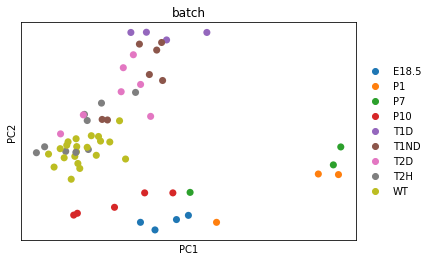

In [7]:
sc.pl.pca(ad, color='batch', s=200)

#### Here's the PCA plot with samples colored by their cluster according to Leiden

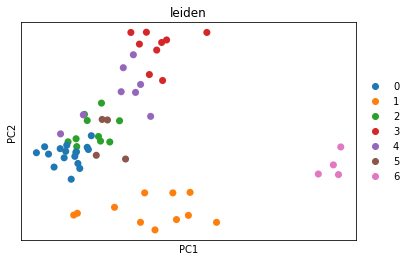

In [8]:
sc.pl.pca(ad, color='leiden', s=200)

## Create Heatmap

In [9]:
WT_VS_DB_plus_UP_WT = [
    #'RN45S',
    #'MIR6236',
    'MT1',
    'SLC2A13',
    'USO1',
    'LYVE1',
    'BRPF3',
    'DCHS1',
    'WNK4',
    'PRR12',
    'CITED2',
    'CRTC1',
    'HEG1',
    'ZBTB20',
    'TNR',
    'PABPC1',
    'CD47',
    'MUC4',
    'HIPK2',
    'EIF4EBP2',
    'UBQLN2',
    'AGO2',
    'GPC4',
    'IREB2',
    'MSLN',
    'ZKSCAN3'
]

WT_VS_DB_plus_UP_DB = [
    #'SPINK1',
    'TRY10',
    'SDC4',
    'D1ERTD622E',
    'DDX3Y',
    'COX6A2',
    'IFRD1',
    'H2-Q4',
    'CDK2AP2',
    'BBC3',
    'CRELD2',
    'CHAC1', 
    #'MANF', # Why is this repeated in their paper?
    'NUPR1',
    'RHOB',
    'CYR61',
    'KLF10',
    'KLF6',
    'SRF',
    'JUNB',
    'RBM15B',
    'JUN',
    'MANF',
    'DNAJB1',
    'DNAJA4',
    'NFKBIA'
]

In [10]:
df_counts = pd.read_csv('Raw_Matrix_filter_rmDup.tsv', sep='\t')
df_counts = df_counts.set_index('GENE_ID')
df_counts

,T729_T2D,T737_T2H,Q203_E18.5,Q204_P1,T222_T1D,Q225_T1ND,Q279_T2D_XXX,T286.1_T2H,Q287_WT,Q292_WT,...,Q792_WT,Q819_WT,T843_WT,T880_WT,Q890_WT,Q891_T1ND,Q896_T1ND,Q897_T1ND,Q899_T1ND,Q918_T2H
GENE_ID,,,,,,,,,,,,,,,,,,,,,
0610007P14RIK,1233.00,1212.00,1039.97,1179.96,586.07,465.44,404.90,497.26,590.16,490.99,...,369.03,655.94,752.62,632.23,532.46,717.28,543.89,579.59,378.01,439.85
0610009B22RIK,6048.40,3608.59,3554.90,3224.48,1475.05,1309.53,1348.77,1427.68,1299.68,1846.15,...,1525.98,1570.52,1973.26,1772.51,1641.50,1856.05,1863.37,1309.23,1120.49,1493.43
0610009D07RIK,2608.15,3372.00,6266.52,6086.78,1928.94,1871.15,1517.46,2254.95,2485.87,2210.91,...,2500.21,2293.26,2848.21,2637.55,2210.99,2329.88,1450.88,1841.17,1764.46,2228.42
0610009O20RIK,292.00,480.98,335.45,424.02,200.61,143.00,264.09,209.32,304.65,165.48,...,253.14,284.00,229.58,233.00,209.03,437.00,105.03,225.07,168.41,202.00
0610010F05RIK,1365.00,1127.70,808.69,1056.00,744.33,597.00,1344.31,677.08,1256.51,577.00,...,655.97,628.09,1052.94,1439.23,715.39,722.00,461.00,1456.85,520.59,532.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX,163.03,281.00,523.00,1686.00,609.00,124.99,229.72,5.07,98.00,50.00,...,91.00,139.00,72.00,112.00,107.00,186.00,268.97,476.01,271.03,143.00
ZZEF1,871.00,1386.00,1087.45,899.73,1070.20,739.58,794.05,526.45,814.36,966.48,...,1032.92,999.06,1093.02,762.83,873.41,1125.93,473.00,667.70,767.61,783.58
ZZZ3,1231.03,1294.00,759.35,1311.79,660.59,623.00,2413.77,753.55,1764.66,902.24,...,1013.43,1134.73,1656.51,1441.79,1052.67,960.32,476.00,1417.36,684.39,484.00


In [11]:
X_log_cpm = np.array([
    x / sum(x)
    for x in np.array(df_counts).T
])
X_log_cpm *= 1e6
X_log_cpm = np.log2(X_log_cpm+1)

df_log2cpm = pd.DataFrame(
    data=X_log_cpm,
    index=df_counts.columns,
    columns=df_counts.index
)
df_log2cpm = df_log2cpm.transpose()
df_log2cpm

,T729_T2D,T737_T2H,Q203_E18.5,Q204_P1,T222_T1D,Q225_T1ND,Q279_T2D_XXX,T286.1_T2H,Q287_WT,Q292_WT,...,Q792_WT,Q819_WT,T843_WT,T880_WT,Q890_WT,Q891_T1ND,Q896_T1ND,Q897_T1ND,Q899_T1ND,Q918_T2H
GENE_ID,,,,,,,,,,,,,,,,,,,,,
0610007P14RIK,4.145550,4.285289,4.637141,4.812057,4.017275,3.963639,3.636546,3.995629,4.117427,3.856451,...,3.404724,4.166163,4.491077,3.927157,4.060541,4.263105,3.895879,4.006407,3.589109,3.703896
0610009B22RIK,6.373527,5.809339,6.368798,6.229449,5.294173,5.395151,5.289001,5.457050,5.210300,5.692175,...,5.345487,5.378198,5.841423,5.352091,5.625179,5.587880,5.602093,5.131104,5.075034,5.387145
0610009D07RIK,5.182771,5.713312,7.179079,7.136991,5.672540,5.899700,5.454907,6.104373,6.127178,5.947685,...,6.043907,5.913382,6.363148,5.913864,6.047308,5.909787,5.249526,5.611065,5.714426,5.953121
0610009O20RIK,2.308750,3.060235,3.121667,3.424294,2.632368,2.455806,3.080571,2.866676,3.239341,2.471128,...,2.921976,3.060071,2.917373,2.641018,2.839517,3.595605,1.880294,2.776641,2.564641,2.706042
0610010F05RIK,4.284373,4.186803,4.290744,4.657945,4.343075,4.302252,5.284345,4.416733,5.162904,4.074405,...,4.173763,4.107130,4.957092,5.059750,4.464318,4.272076,3.674653,5.281061,4.017620,3.959995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX,1.681631,2.402950,3.701682,5.311426,4.069285,2.299006,2.904711,0.204697,1.893809,1.246839,...,1.750602,2.199290,1.611483,1.814633,2.053844,2.515949,2.975817,3.741769,3.155696,2.296154
ZZEF1,3.677609,4.469508,4.699015,4.436791,4.845132,4.597060,4.550209,4.072901,4.558920,4.783643,...,4.799318,4.745305,5.009284,4.181740,4.740374,4.886082,3.708857,4.198680,4.548893,4.487564
ZZZ3,4.143373,4.375041,4.204704,4.959685,4.179871,4.360698,6.112271,4.564239,5.641229,4.688139,...,4.772833,4.922565,5.593792,5.062237,5.000476,4.664941,3.717283,5.242448,4.390813,3.831757


### Figure 1C

Shape of matrix after filtering:  (14442, 30)
Removing transcripts with 100 th quantile < = 0 
14438 transcripts will be tested


R[write to console]: iteration 1 done 


R[write to console]: time 47.39 


R[write to console]: iteration 2 done 


R[write to console]: time 36.67 


R[write to console]: iteration 3 done 


R[write to console]: time 17.73 


R[write to console]: iteration 4 done 


R[write to console]: time 15.68 


R[write to console]: iteration 5 done 


R[write to console]: time 15.62 


R[write to console]: iteration 6 done 


R[write to console]: time 15.62 


R[write to console]: iteration 7 done 


R[write to console]: time 16.54 


R[write to console]: iteration 8 done 


R[write to console]: time 15.64 


R[write to console]: iteration 9 done 


R[write to console]: time 15.47 


R[write to console]: iteration 10 done 


R[write to console]: time 15.07 


R[write to console]: iteration 11 done 


R[write to console]: time 15.64 


R[write to console]: iteration 12 done 


R[write to console]: time 16.67 


R[write to console]: iteration 13 done 


R[write to console]: time 15.94 


R[write 

[1] 14442     2
[1] "alpha:"
            [,1]
iter1  0.7100662
iter2  0.7554954
iter3  0.7569497
iter4  0.7572923
iter5  0.7547630
iter6  0.7564284
iter7  0.7553585
iter8  0.7553585
iter9  0.7553585
iter10 0.7553585
iter11 0.7553585
iter12 0.7553585
iter13 0.7553585
iter14 0.7553585
iter15 0.7553585
[1] "beta:"
             Ng1
iter1   9.619054
iter2  11.377730
iter3  11.466497
iter4  11.487683
iter5  11.451823
iter6  11.474804
iter7  11.458330
iter8  11.458330
iter9  11.458330
iter10 11.458330
iter11 11.458330
iter12 11.458330
iter13 11.458330
iter14 11.458330
iter15 11.458330
[1] "p:"
            [,1]
iter1  0.1986839
iter2  0.1723299
iter3  0.1618739
iter4  0.1566692
iter5  0.1550227
iter6  0.1537427
iter7  0.1535544
iter8  0.1535544
iter9  0.1535544
iter10 0.1535544
iter11 0.1535544
iter12 0.1535544
iter13 0.1535544
iter14 0.1535544
iter15 0.1535544


/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


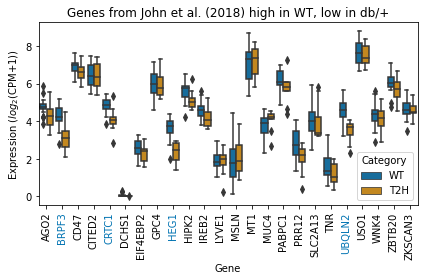

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


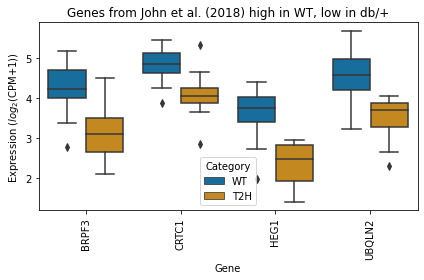

In [48]:
run_analysis(
    WT_VS_DB_plus_UP_WT, 
    'WT', 
    'T2H', 
    'Genes from John et al. (2018) high in WT, low in db/+', 
    './results/genes_from_John_Fig_1C'
)

### Figure 1D

Shape of matrix after filtering:  (7029, 30)


R[write to console]: iteration 1 done 


R[write to console]: time 20.38 


R[write to console]: iteration 2 done 


R[write to console]: time 9.7 


R[write to console]: iteration 3 done 


R[write to console]: time 7.95 


R[write to console]: iteration 4 done 


R[write to console]: time 7.5 


R[write to console]: iteration 5 done 


R[write to console]: time 8.16 


R[write to console]: iteration 6 done 


R[write to console]: time 7.98 


R[write to console]: iteration 7 done 


R[write to console]: time 7.59 


R[write to console]: iteration 8 done 


R[write to console]: time 8.15 


R[write to console]: iteration 9 done 


R[write to console]: time 7.79 


R[write to console]: iteration 10 done 


R[write to console]: time 7.62 


R[write to console]: iteration 11 done 


R[write to console]: time 7.92 


R[write to console]: iteration 12 done 


R[write to console]: time 8.39 


R[write to console]: iteration 13 done 


R[write to console]: time 8.08 


R[write to console]: i

[1] 7029    2
[1] "alpha:"
           [,1]
iter1  1.304125
iter2  1.334558
iter3  1.337109
iter4  1.335435
iter5  1.335212
iter6  1.337505
iter7  1.336621
iter8  1.336621
iter9  1.336621
iter10 1.336621
iter11 1.336621
iter12 1.336621
iter13 1.336621
iter14 1.336621
iter15 1.336621
[1] "beta:"
            Ng1
iter1  59.74252
iter2  62.24552
iter3  62.35289
iter4  62.30025
iter5  62.23433
iter6  62.42636
iter7  62.27564
iter8  62.27564
iter9  62.27564
iter10 62.27564
iter11 62.27564
iter12 62.27564
iter13 62.27564
iter14 62.27564
iter15 62.27564
[1] "p:"
            [,1]
iter1  0.1386480
iter2  0.1437031
iter3  0.1459470
iter4  0.1465881
iter5  0.1467730
iter6  0.1469397
iter7  0.1471575
iter8  0.1471575
iter9  0.1471575
iter10 0.1471575
iter11 0.1471575
iter12 0.1471575
iter13 0.1471575
iter14 0.1471575
iter15 0.1471575


/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


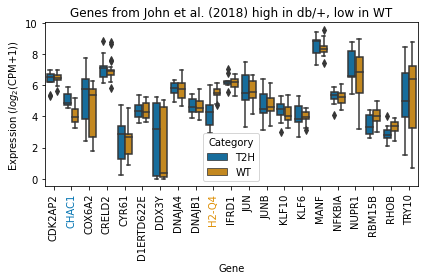

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


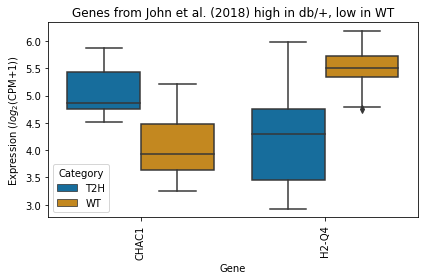

In [38]:
run_analysis(
    WT_VS_DB_plus_UP_DB, 
    'T2H', 
    'WT', 
    'Genes from John et al. (2018) high in db/+, low in WT', 
    './results/genes_from_John_Fig_1D'
)

In [39]:
DB_plus_VS_DB_DB_UP_DB_plus = [
    'VDR',
    'GJD2',
    'MAOB',
    'CCND2',
    'TRIM37',
    #'CARMIL3',
    'UCN3',
    'SLC30A8',
    'TRPM5',
    'TFRC',
    'SYTL4',
    'SFRP5',
    #'T2',
    'RASD1',
    'TMEM8',
    'PRSS53',
    'GAD1',
    'PPP1R1A',
    'SLC2A2',
    'HADH',
    'LIFR',
    'ERO1LB',
    'FPGT',
    'COX6A2',
    'GLUL',
    'NR4A1',
    'SLC4A7',
    'LRRN1',
    'CABP7',
    'ZDHHC2',
    'SEPSECS',
    'TSPYL4',
    'NEUROD1',
    'SPHKAP',
    'AP1S2',
    'FKBP1B',
    'INS1',
    'NPAS4',
    'TMEM215',
    'GIPR',
    'TMEM206',
    'MNS1',
    'IVD',
    'ITPKB',
    'JPH3',
    'PCSK9',
    'KCNG3',
    'KCNF1',
    'SCD2',
    'NKX6-1'
    #'ERO1LB'  # This gene appears twice in their figure
]

DB_plus_VS_DB_DB_UP_DB_DB = [
    'C3',
    'PRSS3',
    'RGS5',
    'GPC4',
    'COL5A1',
    'PAMR1',
    'FAM129A',
    'DNAH11',
    'SERPINA7',
    'ARRDC4',
    'INHBB',
    'TNFRSF11B',
    'PON3',
    'FAM167A',
    'LGALS3BP',
    'SORCS2',
    'ALDH1A3',
    'NDUFA1',
    'REG3B',
    'CTHRC1',
    'FKBP11',
    'SEC11C',
    'DIO1',
    'CD24A',
    'ERLEC1',
    'SEMA3C',
    'RHOU',
    'GC',
    'SEL1L3',
    'KDELR3',
    'EDEM2',
    'DAPL1',
    'SLC17A9',
    'TMED3',
    'COL16A1',
    'ITM2C',
    'RASGRF2',
    'COL27A1',
    'CHGB',
    'CCL28',
    'TACC2',
    'SCARF2',
    'NUCB2',
    'BAMBI',
    'HAPLN4',
    'DNAH9',
    'ELL2',
    'PTPRN',
    'SLC26A2',
    'PAPPA2'
]

#print(set(DB_plus_VS_DB_DB_UP_DB_plus) - set(df_counts.index))

#from collections import Counter
#Counter(DB_plus_VS_DB_DB_UP_DB_plus)

### Figure 1F

Shape of matrix after filtering:  (7029, 16)


R[write to console]: iteration 1 done 


R[write to console]: time 13.11 


R[write to console]: iteration 2 done 


R[write to console]: time 8.31 


R[write to console]: iteration 3 done 


R[write to console]: time 5.32 


R[write to console]: iteration 4 done 


R[write to console]: time 4.39 


R[write to console]: iteration 5 done 


R[write to console]: time 4.93 


R[write to console]: iteration 6 done 


R[write to console]: time 4.91 


R[write to console]: iteration 7 done 


R[write to console]: time 4.58 


R[write to console]: iteration 8 done 


R[write to console]: time 4.73 


R[write to console]: iteration 9 done 


R[write to console]: time 4.7 


R[write to console]: iteration 10 done 


R[write to console]: time 4.51 


R[write to console]: iteration 11 done 


R[write to console]: time 4.42 


R[write to console]: iteration 12 done 


R[write to console]: time 4.41 


R[write to console]: iteration 13 done 


R[write to console]: time 4.36 


R[write to console]: 

[1] 7029    2
[1] "alpha:"
           [,1]
iter1  1.122035
iter2  1.155928
iter3  1.157168
iter4  1.162848
iter5  1.162023
iter6  1.161708
iter7  1.163323
iter8  1.163323
iter9  1.163323
iter10 1.163323
iter11 1.163323
iter12 1.163323
iter13 1.163323
iter14 1.163323
iter15 1.163323
[1] "beta:"
            Ng1
iter1  58.49833
iter2  61.62054
iter3  61.73168
iter4  62.19855
iter5  62.08394
iter6  62.07322
iter7  62.17685
iter8  62.17685
iter9  62.17685
iter10 62.17685
iter11 62.17685
iter12 62.17685
iter13 62.17685
iter14 62.17685
iter15 62.17685
[1] "p:"
            [,1]
iter1  0.2315156
iter2  0.2768864
iter3  0.2952124
iter4  0.3029564
iter5  0.3059283
iter6  0.3065775
iter7  0.3074740
iter8  0.3074740
iter9  0.3074740
iter10 0.3074740
iter11 0.3074740
iter12 0.3074740
iter13 0.3074740
iter14 0.3074740
iter15 0.3074740


/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


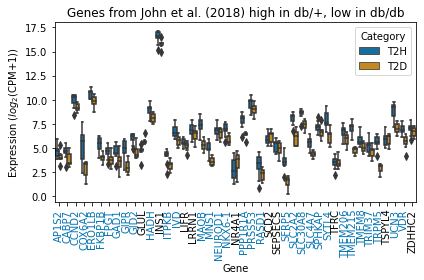

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


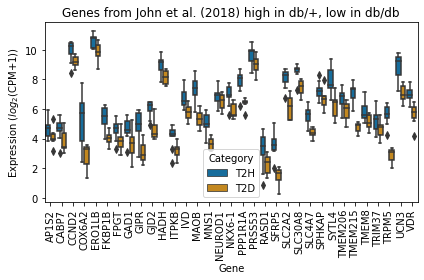

In [40]:
run_analysis(
    DB_plus_VS_DB_DB_UP_DB_plus, 
    'T2H', 
    'T2D', 
    'Genes from John et al. (2018) high in db/+, low in db/db', 
    './results/genes_from_John_Fig_1F'
)

### Figure 1G

Shape of matrix after filtering:  (7029, 16)


R[write to console]: iteration 1 done 


R[write to console]: time 13.24 


R[write to console]: iteration 2 done 


R[write to console]: time 8.96 


R[write to console]: iteration 3 done 


R[write to console]: time 5.11 


R[write to console]: iteration 4 done 


R[write to console]: time 4.86 


R[write to console]: iteration 5 done 


R[write to console]: time 5.26 


R[write to console]: iteration 6 done 


R[write to console]: time 4.35 


R[write to console]: iteration 7 done 


R[write to console]: time 4.63 


R[write to console]: iteration 8 done 


R[write to console]: time 4.79 


R[write to console]: iteration 9 done 


R[write to console]: time 4.79 


R[write to console]: iteration 10 done 


R[write to console]: time 4.47 


R[write to console]: iteration 11 done 


R[write to console]: time 4.48 


R[write to console]: iteration 12 done 


R[write to console]: time 4.46 


R[write to console]: iteration 13 done 


R[write to console]: time 4.37 


R[write to console]:

[1] 7029    2
[1] "alpha:"
           [,1]
iter1  1.122035
iter2  1.155928
iter3  1.157168
iter4  1.162848
iter5  1.162023
iter6  1.161708
iter7  1.163323
iter8  1.163323
iter9  1.163323
iter10 1.163323
iter11 1.163323
iter12 1.163323
iter13 1.163323
iter14 1.163323
iter15 1.163323
[1] "beta:"
            Ng1
iter1  58.49833
iter2  61.62054
iter3  61.73168
iter4  62.19855
iter5  62.08394
iter6  62.07322
iter7  62.17685
iter8  62.17685
iter9  62.17685
iter10 62.17685
iter11 62.17685
iter12 62.17685
iter13 62.17685
iter14 62.17685
iter15 62.17685
[1] "p:"
            [,1]
iter1  0.2315156
iter2  0.2768864
iter3  0.2952124
iter4  0.3029564
iter5  0.3059283
iter6  0.3065775
iter7  0.3074740
iter8  0.3074740
iter9  0.3074740
iter10 0.3074740
iter11 0.3074740
iter12 0.3074740
iter13 0.3074740
iter14 0.3074740
iter15 0.3074740


/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


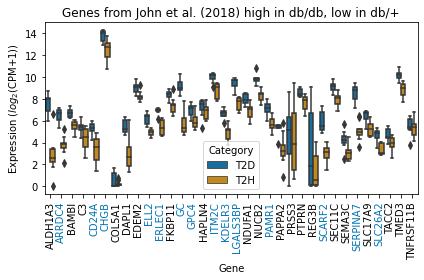

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


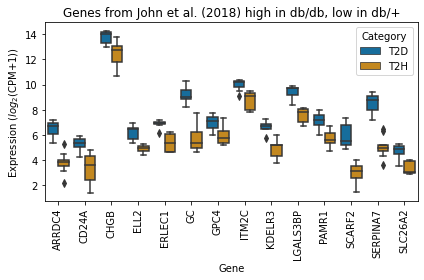

In [41]:
run_analysis(
    DB_plus_VS_DB_DB_UP_DB_DB, 
    'T2D',
    'T2H', 
    'Genes from John et al. (2018) high in db/db, low in db/+', 
    './results/genes_from_John_Fig_1G'
)

In [43]:
WT_VS_DB_DB_UP_WT = [
    'VDR',
    'GIPR',
    'MAOB',
    'FPGT',
    'SCD2',
    'KCNG3',
    'PCSK9',
    'SYTL4',
    'SLC2A2',
    'TRPM5',
    'VWA5B1',
    'SLC30A8',
    #'CARMIL3',
    'GAD1',
    'SPHKAP',
    'SYT14',
    'CABP7',
    'AP1S2',
    'SLC4A7',
    #'T2',
    'FMN2',
    'MAFA',
    'CCND2',
    'ERO1LB',
    'MT1',
    'ABHD2',
    'NKX6-1',
    'FKBP1B',
    'IVD',
    'ITPKB',
    'GJD2',
    'TFRC',
    'PPP1R1A',
    'HADH',
    'PRSS53',
    'UCN3',
    'SFRP5',
    'COX6A2',
    'NPAS4',
    'TMEM215',
    'GLUL',
    'LIFR',
    'TMEM8',
    'CRYL1',
    #'D5ERTD57', # The end of this gene is cut off in the figure
    'TMEM206',
    'MLXIPL',
    'LRRN1',
    'FFAR1',
    'GLP1R',
    'INS1'
]

WT_VS_DB_DB_UP_DB_DB = [
    'CD24A',
    'ARRDC4',
    'GC',
    'RHOU',
    'SEMA3C',
    'DIO1',
    'FAM129A',
    'LGALS3BP',
    'PAMR1',
    'SERPINA7',
    'COL5A1',
    'IGFBP3',
    'COL5A2',
    'ALDH1A3',
    'SORCS2',
    'FAM167A',
    'TNFRSF11B',
    'INHBB',
    'TMED6',
    'PON3',
    'NUCB2',
    'SCARF2',
    'BAMBI',
    'HAPLN4',
    'CCL28',
    'DNAH9',
    'SEL1L3',
    'COL27A1',
    'ITM2C',
    'SERPINI1',
    'SEC11C',
    'KDELR3',
    'GMDS',
    'FKBP11',
    'TMED3',
    'CTHRC1',
    'CHGB',
    'ELL2',
    'PAPPA2',
    'RASGRF2',
    'COL16A1',
    'DAPL1',
    'SIL1',
    'PTPRN',
    'SLC26A2',
    'PRSS1',
    'PRSS3'
]

print(set(WT_VS_DB_DB_UP_DB_DB) - set(df_counts.index))

#from collections import Counter
#Counter(DB_plus_VS_DB_DB_UP_DB_plus)

set()


### Figure 2A

Shape of matrix after filtering:  (7029, 28)


R[write to console]: iteration 1 done 


R[write to console]: time 20.24 


R[write to console]: iteration 2 done 


R[write to console]: time 8.8 


R[write to console]: iteration 3 done 


R[write to console]: time 7.27 


R[write to console]: iteration 4 done 


R[write to console]: time 7.49 


R[write to console]: iteration 5 done 


R[write to console]: time 7.41 


R[write to console]: iteration 6 done 


R[write to console]: time 7.55 


R[write to console]: iteration 7 done 


R[write to console]: time 7.29 


R[write to console]: iteration 8 done 


R[write to console]: time 7.06 


R[write to console]: iteration 9 done 


R[write to console]: time 7.23 


R[write to console]: iteration 10 done 


R[write to console]: time 6.95 


R[write to console]: iteration 11 done 


R[write to console]: time 6.97 


R[write to console]: iteration 12 done 


R[write to console]: time 7.04 


R[write to console]: iteration 13 done 


R[write to console]: time 7.4 


R[write to console]: i

[1] 7029    2
[1] "alpha:"
            [,1]
iter1  0.9876603
iter2  1.0150020
iter3  1.0172397
iter4  1.0187757
iter5  1.0211886
iter6  1.0213327
iter7  1.0199935
iter8  1.0199935
iter9  1.0199935
iter10 1.0199935
iter11 1.0199935
iter12 1.0199935
iter13 1.0199935
iter14 1.0199935
iter15 1.0199935
[1] "beta:"
            Ng1
iter1  47.17475
iter2  49.65081
iter3  49.86428
iter4  50.01541
iter5  50.18728
iter6  50.23437
iter7  50.14837
iter8  50.14837
iter9  50.14837
iter10 50.14837
iter11 50.14837
iter12 50.14837
iter13 50.14837
iter14 50.14837
iter15 50.14837
[1] "p:"
            [,1]
iter1  0.4080309
iter2  0.5078924
iter3  0.5440456
iter4  0.5572414
iter5  0.5614419
iter6  0.5634358
iter7  0.5641814
iter8  0.5641814
iter9  0.5641814
iter10 0.5641814
iter11 0.5641814
iter12 0.5641814
iter13 0.5641814
iter14 0.5641814
iter15 0.5641814


/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


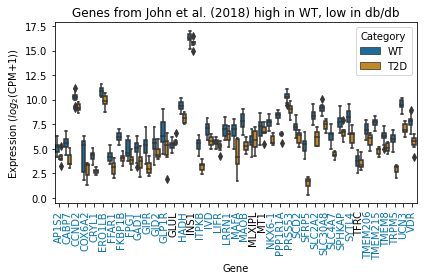

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


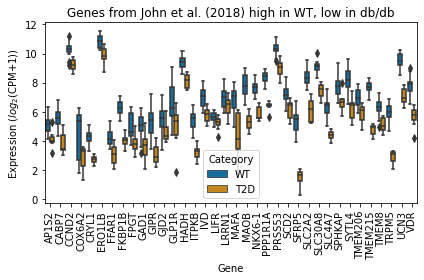

In [44]:
run_analysis(
    WT_VS_DB_DB_UP_WT, 
    'WT',
    'T2D', 
    'Genes from John et al. (2018) high in WT, low in db/db', 
    './results/genes_from_John_Fig_2A'
)

### Figure 2B

In [ ]:
run_analysis(
    WT_VS_DB_DB_UP_DB_DB, 
    'T2D',
    'WT', 
    'Genes from John et al. (2018) high in db/db, low in WT', 
    './results/genes_from_John_Fig_2B'
)

In [ ]:
from scipy.stats import zscore
import seaborn as sns

X_zscore = zscore(np.array(df_log2cpm_plot), axis=1)
df_zscore = pd.DataFrame(
    data=X_zscore,
    index=df_log2cpm_plot.index,
    columns=df_log2cpm_plot.columns
)

gene_group_to_genes = {
    'High WT+': WT_VS_DB_plus_UP_WT,
    'High DB': WT_VS_DB_plus_UP_DB
    #'Immature beta cell': IMMATURE_BETA_CELL_GENES,
    #'Beta cell disallowed': BETA_CELL_DISALLOWED,
    #'Islet hormones': ISLET_HORMONES
}

CATEGORIES_ORDER = ['WT', 'T2H']
GENE_GROUP_ORDER = ['High WT+', 'High DB']

ordered_samples = []
new_X = []
for cat in CATEGORIES_ORDER:
    cat_df = df_zscore[category_to_samples[cat]]
    cg = sns.clustermap(cat_df, row_cluster=False, col_cluster=True)
    inds = cg.dendrogram_col.reordered_ind
    ordered_samples += list(np.array(cat_df.columns)[inds])
    
ordered_genes = []
for gg in GENE_GROUP_ORDER:
    gg_df = df_zscore.loc[gene_group_to_genes[gg]]
    cg = sns.clustermap(gg_df, row_cluster=True, col_cluster=False)
    inds = cg.dendrogram_row.reordered_ind
    ordered_genes += list(np.array(gg_df.index)[inds])

In [ ]:
PALETTE_2 = [
    '#00ba79',
    #'#417be8',
    '#c654e3',
    '#fad05c'
]

# Get all of the column categories
categories = []
for cat in CATEGORIES_ORDER:
    categories += list(np.full(len(category_to_samples[cat]), cat)) 

# Get all of the column labels
category_to_label = {
    'WT': 'Wild-type',
    'T2H': 'T2H'
    #'T1ND': 'Healthy adult',
    #'T2D': 'Diabetic',
    #'T1D': 'Diabetic',
    #'E18.5': 'Development',
    #'P1': 'Development',
    #'P7': 'Development',
    #'P10': 'Development'
}   
labels = []
for cat in CATEGORIES_ORDER:
    labels += list(np.full(len(category_to_samples[cat]), category_to_label[cat]))

    
# Get the row gene groups
gene_group = []
for gg in GENE_GROUP_ORDER:
    gene_group += list(np.full(len(gene_group_to_genes[gg]), gg))

# Map the rows to their colors
gene_group_to_color = {
    gg: sns.color_palette("Accent")[g_i] 
    for g_i, gg in enumerate(sorted(set(gene_group)))
}
row_colors = [gene_group_to_color[cat] for cat in gene_group]

# Map the columns to their colors
cat_to_color = {
    cat: PALETTE_2[cat_i] #sns.color_palette("Accent")[cat_i] 
    for cat_i, cat in enumerate(sorted(set(labels)))
}
col_colors = [cat_to_color[cat] for cat in labels]


# Re-order the columns and rename them
df_zscore = df_zscore[ordered_samples]
df_zscore = df_zscore.loc[ordered_genes]
df_zscore = df_zscore.rename(
    sample_to_category,
    axis='columns'
)

# Create the plot
cg = sns.clustermap(
    df_zscore, 
    cmap='bwr',
    col_cluster=False,
    row_cluster=False,
    col_colors=col_colors,
    row_colors=row_colors,
    xticklabels=1,
    yticklabels=1,
    figsize=(12,10)
)
cg.ax_heatmap.set_ylabel('Marker gene')
cg.ax_heatmap.set_xlabel('Sample')
cg.ax_cbar.set_ylabel('Expression z-score')

gene_patches = [
    mpatches.Patch(color=sns.color_palette("Accent")[g_i], label=gg)
    for g_i, gg in enumerate(sorted(set(gene_group)))
]
first_legend = plt.legend(handles=gene_patches, title='Gene groups', bbox_to_anchor=(0.3, 0.99), bbox_transform=plt.gcf().transFigure, loc='upper right')

ax = plt.gca().add_artist(first_legend)
sample_patches = [
    mpatches.Patch(color=PALETTE_2[cat_i], label=cat)
    for cat_i, cat in enumerate(sorted(set(labels)))
]
plt.legend(handles=sample_patches, title='Sample groups', bbox_to_anchor=(0.45, 0.99), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.show()

# Save figure
cg.savefig('results/marker_gene_heatmap.tiff', format='tiff', dpi=150)
cg.savefig('results/marker_gene_heatmap.pdf', format='pdf')

cg = sns.clustermap(
    df_zscore, 
    cmap='bwr',
    col_cluster=False,
    row_cluster=True,
    col_colors=col_colors,
    row_colors=row_colors,
    xticklabels=1,
    yticklabels=1,
    figsize=(12,10)
)
cg.ax_heatmap.set_ylabel('Marker gene')
cg.ax_heatmap.set_xlabel('Sample')
cg.ax_cbar.set_ylabel('Expression z-score')

gene_patches = [
    mpatches.Patch(color=sns.color_palette("Accent")[g_i], label=gg)
    for g_i, gg in enumerate(sorted(set(gene_group)))
]
first_legend = plt.legend(handles=gene_patches, title='Gene groups', bbox_to_anchor=(0.3, 0.99), bbox_transform=plt.gcf().transFigure, loc='upper right')

ax = plt.gca().add_artist(first_legend)
sample_patches = [
    mpatches.Patch(color=PALETTE_2[cat_i], label=cat)
    for cat_i, cat in enumerate(sorted(set(labels)))
]
plt.legend(handles=sample_patches, title='Sample groups', bbox_to_anchor=(0.45, 0.99), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.show()

# Save figure
cg.savefig('results/marker_gene_heatmap.clust_genes.tiff', format='tiff', dpi=150)
cg.savefig('results/marker_gene_heatmap.clust_genes.pdf', format='pdf')